# Space Images Classifier - Using Kaggle dataset

https://www.kaggle.com/datasets/abhikalpsrivastava15/space-images-category?utm_source=chatgpt.com

### Notebook 6 - Training stage 3 (Unfrozen entire backbone for full fine-tuning)

# Import librairies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import json

# Add the root folder to Python's module search path
sys.path.append(os.path.abspath(os.path.join(".."))) 
# Import the project configuration
from config import DEVICE, OUTPUT_PATH, BATCH_SIZE, NUM_WORKERS, EPOCHS_STAGE3, LEARNING_RATE_STAGE3
from models import SpaceClassifier
from train_utils import train_epoch, validate
from datasets import SpaceImageDataset, train_transforms, val_test_transforms

import shutil
from pathlib import Path
import cv2
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight

# Load callback/config variables

In [2]:
ROOT_PATH = Path("..")
# Path to load JSON
CONFIG_JSON_PATH = ROOT_PATH / "config_dynamic.json"

try:
    with open(CONFIG_JSON_PATH) as f:
        dynamic_config = json.load(f)
except FileNotFoundError:
    dynamic_config = {}
    
NUM_CLASSES = dynamic_config.get("NUM_CLASSES", 0)
class_names = dynamic_config.get("class_names", [])
split_success = dynamic_config.get("split_success", 5)

# Path to the saved tensor
WEIGHTS_PATH = Path("models") / "class_weights_tensor.pth"

# Load the tensor
class_weights_tensor = torch.load(WEIGHTS_PATH, map_location=DEVICE)



# Training stage 3 with unfrozen entire backbone

## Load the best model from stage 2

In [ ]:
# Create model
model = SpaceClassifier(NUM_CLASSES, pretrained=True)
model = model.to(DEVICE)

print("=" * 80)
print(f"Model created: EfficientNet-B0")
print(f"Device: {DEVICE}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
print("-" * 80)

# Load best model
model.load_state_dict(torch.load('models/stage2_best.pth'))
print("Best model from stage 2 loaded")
# Load logs from stage1 and stage2
history_stage1 = torch.load('models/history_stage1_del_img.pt')
history_stage2 = torch.load('models/history_stage2.pt')
print("History of the stages 1 and 2 loaded")
print("=" * 80)

Model created: EfficientNet-B0
Device: mps
Total parameters: 4,337,026
Trainable parameters: 329,478
--------------------------------------------------------------------------------
Best model from stage 2 loaded
History of the stages 1 and 2 loaded


## Create Dataset

In [4]:
train_dataset = SpaceImageDataset(OUTPUT_PATH / "train", transform=train_transforms)
val_dataset = SpaceImageDataset(OUTPUT_PATH / "validation", transform=val_test_transforms)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Dataset created from ../space_images_split/train
   -> 765 valid images
7 images skipped (see ../space_images_split/train/skipped_images.txt)
Dataset created from ../space_images_split/validation
   -> 161 valid images
2 images skipped (see ../space_images_split/validation/skipped_images.txt)


## Create Data loaders

In [5]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE.type == 'mps' else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE.type == 'mps' else False
)

## Training the model - Stage 3

Unfrozen the entire backbone, fine-tuning on the whole backbone

In [6]:
if split_success and history_stage1:
    # Unfreeze for stage 3
    model.unfreeze_backbone_stage(stage=3)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE_STAGE3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,}")
    
    print("=" * 80)
    print(f"Starting Stage 3 Fine-Tuning")
    print("-" * 80)
    print(f"Estimated time on M1: 20-40 minutes")

    history_stage3 = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    PATIENCE = 6
    
    for epoch in range(EPOCHS_STAGE3):
        print("=" * 80)
        print(f"Epoch {epoch+1}/{EPOCHS_STAGE3}")
        print("-" * 60)
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, DEVICE)
        
        scheduler.step(val_loss)
        
        history_stage3['train_loss'].append(train_loss)
        history_stage3['train_acc'].append(train_acc)
        history_stage3['val_loss'].append(val_loss)
        history_stage3['val_acc'].append(val_acc)
        
        print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'models/stage3_best.pth')
            print(f"Best model saved! (Val Acc: {val_acc*100:.2f}%)")
            # Save stage 2 logs to the disk
            torch.save(history_stage3, 'models/history_stage3.pt')
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping triggered (patience={PATIENCE})")
            break
    
    print("\nStage 3 fine-tuning complete!")

else:
    history_stage3 = None

print("=" * 80)

Backbone unfrozen for stage 3
Backbone fully unfrozen for stage 3
Trainable parameters: 4,337,026
Starting Stage 3 Fine-Tuning
--------------------------------------------------------------------------------
Estimated time on M1: 20-40 minutes
Epoch 1/15
------------------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:29<00:00,  4.88s/it, loss=3.3818, acc=62.73%]



Train Loss: 0.5613 | Train Acc: 80.52%
Val Loss:   0.9916 | Val Acc:   62.73%
Best model saved! (Val Acc: 62.73%)
Epoch 2/15
------------------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:24<00:00,  4.11s/it, loss=3.6404, acc=66.46%]



Train Loss: 0.5663 | Train Acc: 80.13%
Val Loss:   0.9780 | Val Acc:   66.46%
Best model saved! (Val Acc: 66.46%)
Epoch 3/15
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:24<00:00,  4.13s/it, loss=3.4200, acc=68.32%]



Train Loss: 0.4842 | Train Acc: 82.88%
Val Loss:   0.9705 | Val Acc:   68.32%
Best model saved! (Val Acc: 68.32%)
Epoch 4/15
------------------------------------------------------------


Training:  50%|█████     | 12/24 [00:08<00:04,  2.61it/s, loss=0.5959, acc=84.90%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:24<00:00,  4.13s/it, loss=3.9412, acc=67.70%]



Train Loss: 0.4607 | Train Acc: 85.23%
Val Loss:   1.0296 | Val Acc:   67.70%
Epoch 5/15
------------------------------------------------------------


Training:  67%|██████▋   | 16/24 [00:10<00:02,  2.77it/s, loss=0.3268, acc=83.98%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:24<00:00,  4.10s/it, loss=3.5897, acc=65.84%]



Train Loss: 0.4613 | Train Acc: 83.14%
Val Loss:   1.0016 | Val Acc:   65.84%
Epoch 6/15
------------------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:24<00:00,  4.08s/it, loss=4.0592, acc=67.08%]



Train Loss: 0.4003 | Train Acc: 85.49%
Val Loss:   1.0215 | Val Acc:   67.08%
Epoch 7/15
------------------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Training:  29%|██▉       | 7/24 [00:07<00:08,  1.93it/s, loss=0.3495, acc=84.82%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:24<00:00,  4.09s/it, loss=3.7047, acc=65.84%]



Train Loss: 0.4101 | Train Acc: 86.27%
Val Loss:   1.0281 | Val Acc:   65.84%
Epoch 8/15
------------------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:24<00:00,  4.06s/it, loss=3.5708, acc=65.84%]



Train Loss: 0.3318 | Train Acc: 88.10%
Val Loss:   1.0482 | Val Acc:   65.84%
Epoch 9/15
------------------------------------------------------------


Training:  12%|█▎        | 3/24 [00:05<00:28,  1.37s/it, loss=0.2973, acc=85.42%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:24<00:00,  4.13s/it, loss=3.9654, acc=67.70%]


Train Loss: 0.3462 | Train Acc: 89.28%
Val Loss:   1.0501 | Val Acc:   67.70%

Early stopping triggered (patience=6)

Stage 3 fine-tuning complete!


## Training visualization (stages 1 to 3)

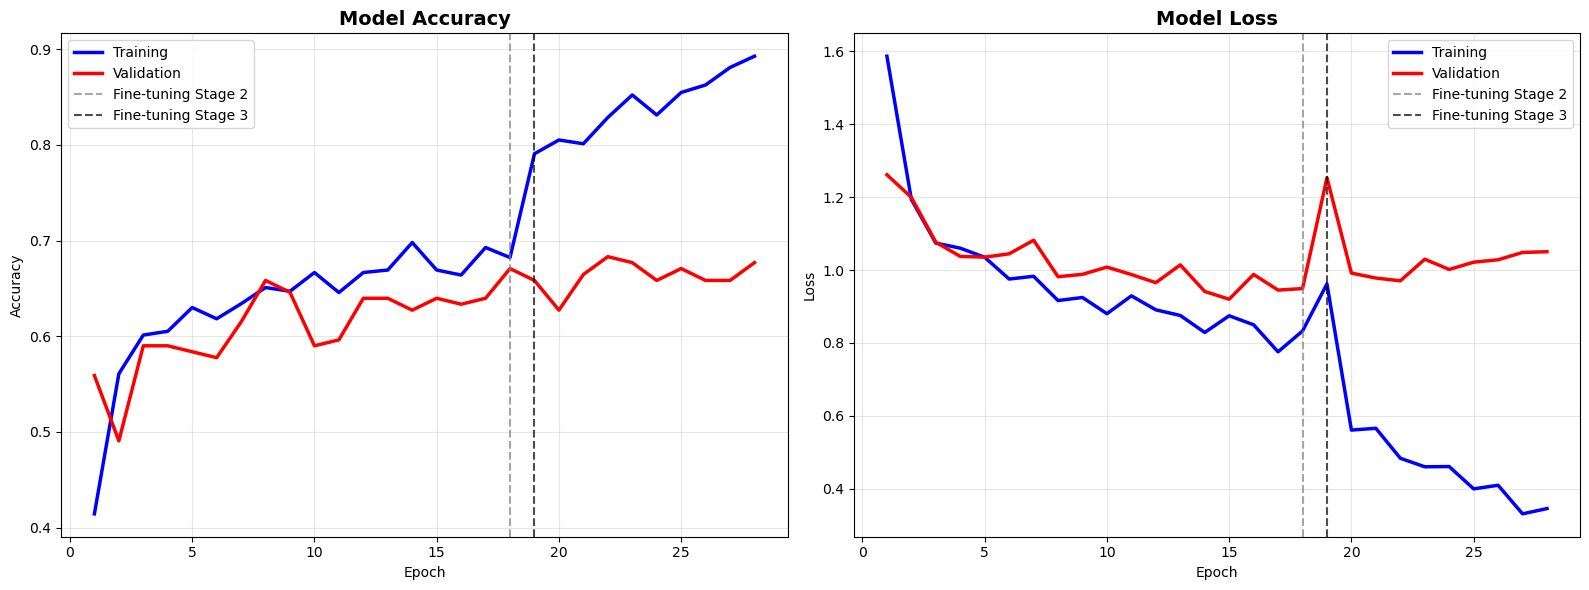

Training curves saved


In [10]:
if history_stage1 and history_stage2 and history_stage3:
    # Combine histories
    train_loss = history_stage1['train_loss'] + history_stage2['train_loss'] + history_stage3['train_loss']
    train_acc  = history_stage1['train_acc']  + history_stage2['train_acc']  + history_stage3['train_acc']
    val_loss   = history_stage1['val_loss']   + history_stage2['val_loss']   + history_stage3['val_loss']
    val_acc    = history_stage1['val_acc']    + history_stage2['val_acc']    + history_stage3['val_acc']

    epochs = range(1, len(train_loss) + 1)
    
    fine_tune_start_1 = len(history_stage1['train_acc'])
    fine_tune_start_2 = len(history_stage1['train_acc']) + len(history_stage2['train_acc'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Accuracy
    ax1.plot(epochs, train_acc, 'b-', label='Training', linewidth=2.5)
    ax1.plot(epochs, val_acc, 'r-', label='Validation', linewidth=2.5)
    ax1.axvline(x=fine_tune_start_1, color='gray', linestyle='--', label='Fine-tuning Stage 2', alpha=0.7)
    ax1.axvline(x=fine_tune_start_2, color='black', linestyle='--', label='Fine-tuning Stage 3', alpha=0.7)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Loss
    ax2.plot(epochs, train_loss, 'b-', label='Training', linewidth=2.5)
    ax2.plot(epochs, val_loss, 'r-', label='Validation', linewidth=2.5)
    ax2.axvline(x=fine_tune_start_1, color='gray', linestyle='--', label='Fine-tuning Stage 2', alpha=0.7)
    ax2.axvline(x=fine_tune_start_2, color='black', linestyle='--', label='Fine-tuning Stage 3', alpha=0.7)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/training_curve_stages123.png', dpi=150)
    plt.show()

    print("Training curves saved")

The first dashed line marks the beginning of the stage 2 (the partial fine-tuning). A noticeable improvement in training accuracy and a slight bump in validation accuracy mean that the backbone started adapting in my dataset.

The second dashed line marks the start of the stage 3 (full fine-tuning of the backbokne). The trainnig accuracy improved strongly (up to ~90%) and the validation accuracy rises slightly (up to ~68% compared to 66% at stage 2)

That’s a normal and expected pattern during full fine-tuning — the model squeezes out the last bit of performance but becomes more specialized to your training set.

# End of notebook 5 - Training stage 2